In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Experiment

We asume the triangle DAG with edges
1. X1 -> X2
2. X2 -> X3
3. X1 -> X3

which we know up to its Markov equivalence class but obtain natural interventions on variables with some degree of sparsity.

We begin with a domain of the original graph, then sample additional domans with some number of interventions. We either then pool all together, or consider pairwise pooling taking the union across pools.

In [18]:
# Meeks rules giving the oritentations are commented above
intervention_dict = {
    # 2 v-structures
    (1,): [1, 3],
    # 2 v-structure, acyclic
    (2,): [1, 2, 3],
    # 2 v-structures
    (3,): [2, 3],
    # 2 v-structures
    (1, 2): [2, 3],
    # 2 v-structures
    (2, 3): [1, 3],
    # 2 v-structures, acyclic
    (1, 3): [1, 2, 3],
    # Nothing
    (1, 2, 3): [],
}

In [19]:
class FullPC:
    def __init__(self):
        self.domains_ = []
        self.interv_edges_ = set()
        
    def add_domain(self, interventions):
        self.interv_edges_.update(interventions)
        self.domains_.append(interventions)
        
    def get_learned_edges(self):
        return intervention_dict[tuple(sorted(self.interv_edges_))]
    
class PairwisePC:
    def __init__(self):
        self.domains_ = []
        self.learned_edges_ = []

    def add_domain(self, interventions):
        self.learned_edges_.append(intervention_dict[tuple(sorted(interventions))])
        
        for prior_domain in self.domains_:
            self.learned_edges_.append(intervention_dict[tuple(
                sorted(np.unique(np.hstack((prior_domain, interventions))))
            )])
        
        self.domains_.append(interventions)
        
    def get_learned_edges(self):
        return np.unique(np.hstack(self.learned_edges_)).astype(int)

In [20]:
print('Pairwise')
fpc = PairwisePC()
fpc.add_domain([2])
print(fpc.get_learned_edges())
fpc.add_domain([3])
print(fpc.get_learned_edges())

print('Full')
fpc = FullPC()
fpc.add_domain([2])
print(fpc.get_learned_edges())
fpc.add_domain([3])
print(fpc.get_learned_edges())

Pairwise
[1 2 3]
[1 2 3]
Full
[1, 2, 3]
[1, 3]


## Experiments

In [33]:
results_mat = []
n_environments = 15
n_reps = 200

for rep in range(n_reps):
    for sparsity in [1, 2, 3]:
        fpc = FullPC()    
        ppc = PairwisePC()
        for n_env in range(2, n_environments+1):
            interventions = tuple(np.random.choice([1, 2, 3], sparsity, replace=False))
            fpc.add_domain(interventions)
            ppc.add_domain(interventions)
            results_mat.append([
                rep, 'Full PC', sparsity, n_env, len(fpc.get_learned_edges()) / 3
            ])
            results_mat.append([
                rep, 'Pairwise PC', sparsity, n_env, len(ppc.get_learned_edges()) / 3
            ])

In [34]:
df = pd.DataFrame(
    results_mat,
    columns=['Rep', 'Method', 'Sparsity', 'Number of environments', 'Fraction of MEC learned'])

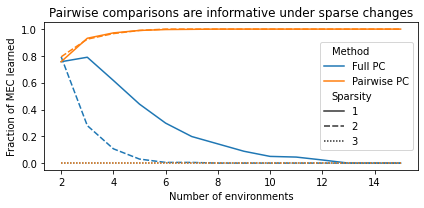

In [35]:
plt.figure(figsize=(6, 3))
sns.lineplot(
    data=df,
    x='Number of environments',
    y='Fraction of MEC learned',
    hue='Method',
    style='Sparsity',
    ci=None,
    # palette='gist_heat'
)
plt.title('Pairwise comparisons are informative under sparse changes')
plt.tight_layout()
plt.savefig('./figures/pairwise_oracle_pc_simulation.pdf')
plt.show()